# New ML Detector

-----------------------

Artash Nath
Founder, MonitorMyOcean.com

--------------------------

In [2]:
1

1

In [1]:
# Importing open-source libraries

# AWS Client Data Libraries
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from numba import jit

# Standard Libaries
import os
from pathlib import Path
import soundfile as sf
import json
import datetime
from datetime import datetime, timedelta
from IPython.display import Audio
from tqdm.notebook import trange, tqdm

# Statistics / Analsyis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.patches import Rectangle
import scipy
import pandas as pd
import cv2
import librosa
from scipy.signal import find_peaks
import sklearn
from scipy.ndimage import convolve
import scipy

# Custom Helper Functions

from helper_functions import*

C:\ProgramData\Anaconda3\envs\oceansoundscape2\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\envs\oceansoundscape2\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\envs\oceansoundscape2\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

----------------
Preliminary Functions and Constants

----------------

In [3]:
# Blue Whale Call Parameters (From MBARI)

BLUE_A = dict(name = 'BlueA',
    freq_range=[(70,90)], duration_secs=25, blur_axis='frequency', num_fft=1024, center=True,  padding_secs=3, num_mels=30)

BLUE_B = dict(name = 'BlueB',
    freq_range=[(40,55)], duration_secs=25, blur_axis='time', num_fft=1024, center=True, padding_secs=2)

BLUE_D = dict(name = 'BlueD',
    freq_range=[(25,75)], duration_secs=7, blur_axis='', num_fft=1024, center=True, padding_secs=2, num_mels=30)

FIN_20 = dict( 
    freq_range=[(10,35)], duration_secs=0, blur_axis='frequency', num_fft=4096, center=False,  padding_secs=3)

# Constants
SAMPLE_RATE = 16000 # Hydrophone File Sample rate
OVERLAP = 0.95 # Overlap when taking precise interst-sample FFTs
IMAGE_SIZE = (224, 224) # Size of sample images being fed into AI models

MBARI_HYDROPHONE_CALIBRATION = 177.9
global MBARI_HYDROPHONE_CALIBRATION

----------------
Downloading Raw Hydrophone Data at 16 kHz from AWS Server

----------------

In [4]:
dates = ['2016-11-01',]

data_path = r'E:\MBARI DATA'

all_filenames = []
all_filenames_full = []

for date in dates:

    
    year = int(date.split('-')[0])
    month = int(date.split('-')[1])
    bucket = 'pacific-sound-16khz'

    # Client to retreive AWS MBARI Raw Acoustic Data
    s3 = boto3.client('s3',
        aws_access_key_id='',
        aws_secret_access_key='',
        config=Config(signature_version=UNSIGNED))

    filenames = []
    for obj in s3.list_objects_v2(Bucket=bucket, Prefix=f'{year:04d}/{month:02d}')['Contents']:
        filenames.append(obj['Key'])

    s3 = boto3.resource('s3',
        aws_access_key_id='',
        aws_secret_access_key='',
        config=Config(signature_version=UNSIGNED))

    # First day in the month    
    n = filenames[int(date.split('-')[2])-1][8:]
    wav_filename_full = os.path.join(data_path, n)
    wav_filename = n
    key = f'{year:04d}/{month:02d}/{wav_filename}'
    print(wav_filename_full)
    # only download if needed
    if not Path(wav_filename_full).exists():

        print('Downloading') 
        s3.Bucket(bucket).download_file(key, wav_filename_full)
        print('Done')
        
    all_filenames.append(wav_filename)
    all_filenames_full.append(wav_filename_full)

E:\MBARI DATA\MARS-20161101T000000Z-16kHz.wav


In [5]:
# Load Blue Whale A-Call Model
whale_model = tf.keras.models.load_model(r"C:\Users\vikas\OneDrive\Artash_Python\2023 Test\1 - Whale Detection\saved_model/multimodel-v3")

def predict(im):
    im  = (im - np.min(im)) / (np.max(im) - np.min(im))
    im = np.reshape(im, (1, 224, 224, 3))
    a = whale_model.predict(im, verbose=0)    
    a = np.around(a, 3)   
    return a[0]

----------------

Spectrum Analysis Functions

----------------

In [27]:
def mel_spectrogram(x, sample_rate, num_fft, OVERLAP, freq_range, duration):
    
    n_mels = 30
    # Optimum mel spectrogram parameters for classification
    PCEN_GAIN = 0.25
    PCEN_BIAS = 2.0
    PCEN_TIME_CONSTANT = 0.6
    
    hop_length = round(num_fft * (1 - OVERLAP))
    
    stft = librosa.feature.melspectrogram(
                            y=sklearn.preprocessing.minmax_scale(x, feature_range=((-2 ** 31), (2 ** 31))),
                            sr=sample_rate,
                            hop_length=hop_length,
                            power=1,
                            n_mels=n_mels,
                            fmin=freq_range[0],
                            fmax=freq_range[1])
    
    stft_pcen = librosa.pcen(stft * (2 ** 31), sr=sample_rate,
                                                 hop_length=hop_length,
                                                 gain=PCEN_GAIN, bias = PCEN_BIAS,
                                                 time_constant=PCEN_TIME_CONSTANT)
    
    stft_pcen = smooth(stft_pcen, 'frequency')
    
    im = colorizeDenoise(stft_pcen)[:,:,:3]
    
    return im



def mid_freq(a):
    a = np.sum(a, axis=1)
    weights = a/np.sum(a)
    weighted = []
    for c, i in enumerate(weights):
        weighted.append(i*c)
    return np.sum(weighted)

############################################################################################

def Analysis(x_2k, hour, date):
    
    annotations_A = []
    annotations_B = []
    
    sg, f = psd_1sec(x_2k, 2000, MBARI_HYDROPHONE_CALIBRATION) # create calibrated psd
    windows_A = find_windows(sg, BLUE_A)
    windows_B = find_windows(sg, BLUE_B)    
    for t1, t2, f1, f2 in tqdm(windows_A):
        
        #try:
            sample_width = BLUE_A['duration_secs']*2000
            subset = x_2k[(t1*2000):(t2*2000)]
            im = mel_spectrogram(subset, 2000, BLUE_A['num_fft'], OVERLAP, [70, 100], BLUE_A['duration_secs'])
            p = predict(im)[1]
            if p > 0.9:
                area = sg[70:100, t1:t2]
                mid_f = mid_freq(area)
                mid_f+=70
                plt.imshow(area, aspect='auto')
                plt.show()
                plt.imshow(area*np.array(area>np.percentile(area, 90)), aspect='auto')
                plt.show()
                plt.imshow(im, aspect='auto')
                plt.show()
                p50, p90, p99 = np.percentile(area, 50), np.percentile(area, 90), np.percentile(area, 99.9)
                anthro_level = np.mean(sg[56:71, t1:t2])
                annotations_A.append([date, hour, t1, 'BLUE_A', p, sample_width, mid_f, p50, p90, p99, anthro_level])
                name = f'{date}T{hour}-{t1}-BlueA'
                plt.imsave(os.path.join(r'C:\Users\vikas\OneDrive\Artash_Python\2023 Test\1 - Whale Detection\Annotations\Real', name+'.png'), im, origin='lower')
                
            if p < 0.5:
                name = f'{date}T{hour}-{t1}-NoiseA'
                plt.imsave(os.path.join(r'C:\Users\vikas\OneDrive\Artash_Python\2023 Test\1 - Whale Detection\Annotations\Noise2', name+'.png'), im, origin='lower')
                
       # except:
            pass
        
#################################################################################        
        
    for t1, t2, f1, f2 in tqdm(windows_B):
        
        try:
            sample_width = BLUE_B['duration_secs']*2000
            subset = x_2k[(t1*2000):(t2*2000)]
            
            im = mel_spectrogram(subset, 2000, BLUE_B['num_fft'], OVERLAP, [25, 75], BLUE_B['duration_secs'])
            p = predict(im)[2]
            if p > 0.9:
                area = sg[25:75, t1:t2]
                mid_f = mid_freq(area)
                mid_f+=25
                
                p50, p90, p99 = np.percentile(area, 50), np.percentile(area, 90), np.percentile(area, 99.9)
                anthro_level = np.mean(sg[56:71, t1:t2])
                annotations_B.append([date, hour, t1, 'BLUE_B', p, sample_width, mid_f, p50, p90, p99, anthro_level])
                name = f'{date}T{hour}-{t1}-BlueB'
                plt.imsave(os.path.join(r'C:\Users\vikas\OneDrive\Artash_Python\2023 Test\1 - Whale Detection\Annotations\Real', name+'.png'), im, origin='lower')
                    
            if p < 0.5:
                name = f'{date}T{hour}-{t1}-NoiseB'
                plt.imsave(os.path.join(r'C:\Users\vikas\OneDrive\Artash_Python\2023 Test\1 - Whale Detection\Annotations\Noise2', name+'.png'), im, origin='lower')

        except:
            pass
            
    print("{} Confirmed Blue-A calls in hour {}".format(len(annotations_A), hour))
    print("{} Possible Blue-B calls in hour {}".format(len(annotations_B), hour))
    return annotations_A + annotations_B

############################################################################################

def humphback_analysis(x_2k, hour, date):
    
    annotations = []
    sg, f = psd_1sec(x_2k, 2000, MBARI_HYDROPHONE_CALIBRATION) # create calibrated psd
    print(sg.shape)
    x_brk = np.split(x_2k, 72)
    for i, elem in tqdm(enumerate(x_brk)):
        area = sg[100:1000, int(i*50): int((i+1)*50)]
        if np.percentile(area, 99.9) > 81:
            im = mel_spectrogram(elem, 2000, 1024, OVERLAP, [100, 1000], 50)  
            p = predict(im)[3]
            if p > 0.8:
                mid_f = mid_freq(area)
                mid_f+=100
                p50, p90, p99 = np.percentile(area, 50), np.percentile(area, 90), np.percentile(area, 99.9)
                anthro_level = np.mean(sg[56:71, int(i*50): int((i+1)*50)])
                name = f'{date}T{hour}-{(i*50)}-Humphback'

                plt.imsave(os.path.join(r'C:\Users\vikas\OneDrive\Artash_Python\2023 Test\1 - Whale Detection\Annotations\real', name+'.png'), im, origin='lower')
                annotations.append([date, hour, (i*50), 'Humpback', p, 50, mid_f, p50, p90, p99, anthro_level])

            if p < 0.5:
                name = f'{date}T{hour}-{(i*50)}-NoiseH'
                plt.imsave(os.path.join(r'C:\Users\vikas\OneDrive\Artash_Python\2023 Test\1 - Whale Detection\Annotations\Noise2', name+'.png'), im, origin='lower')


    print("{} Confirmed Humpback calls in hour {}".format(len(annotations), hour))
    return annotations
        

----------------
Analyzing Specified Day Hour by Hour

----------------

In [11]:
os.path.join(r'C:\Users\vikas\OneDrive\Artash_Python\2023 Test\1 - Whale Detection\Annotations2', date+'.xlsx')

'C:\\Users\\vikas\\OneDrive\\Artash_Python\\2023 Test\\1 - Whale Detection\\Annotations2\\20161101.xlsx'

MARS-20161101T000000Z-16kHz.wav


  0%|          | 0/20 [00:00<?, ?it/s]

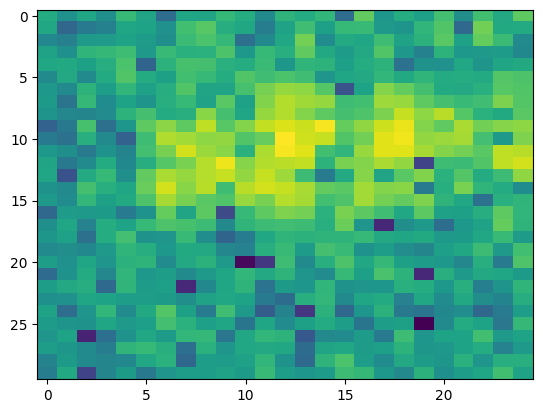

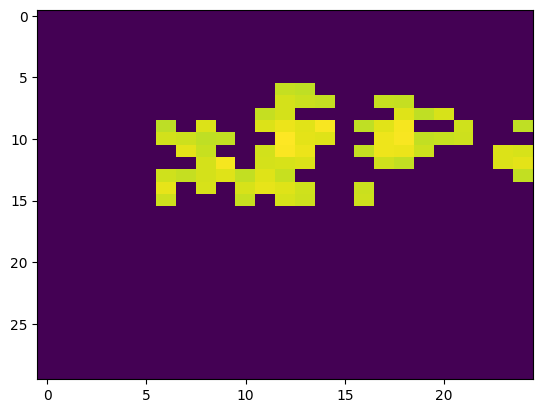

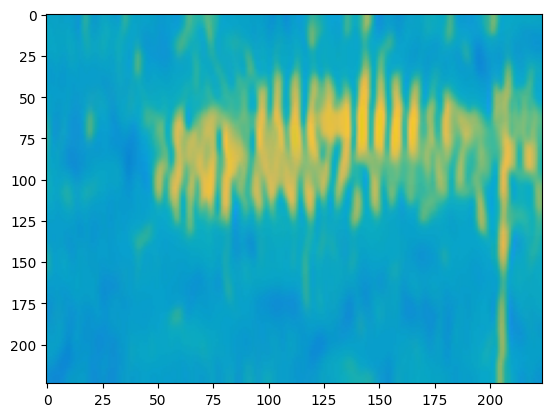

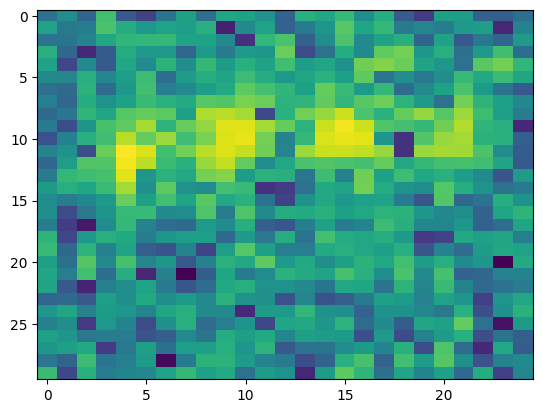

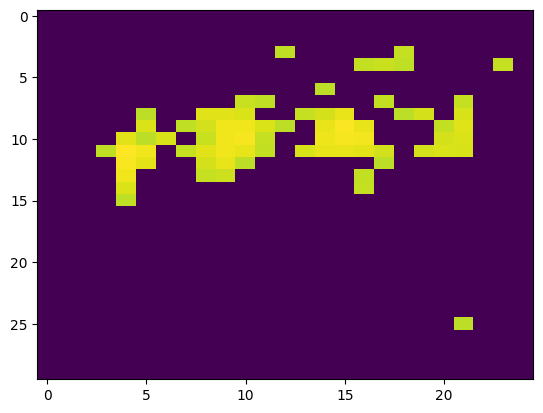

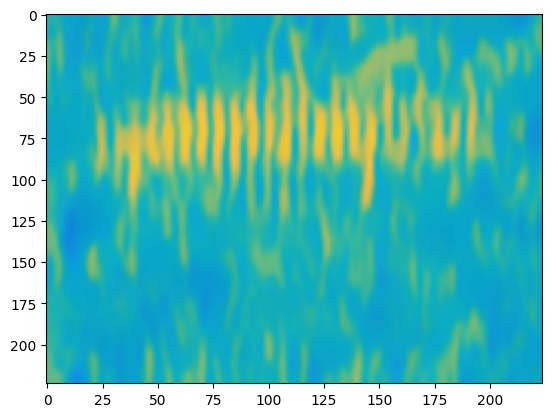

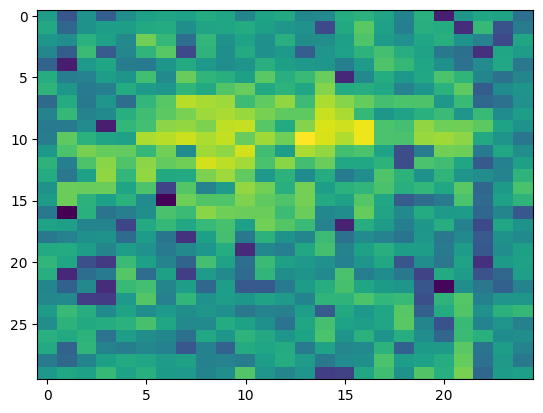

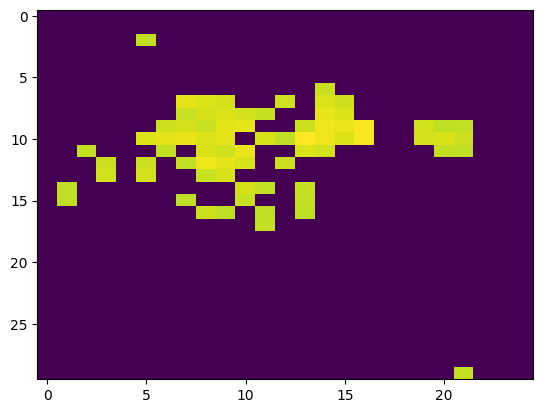

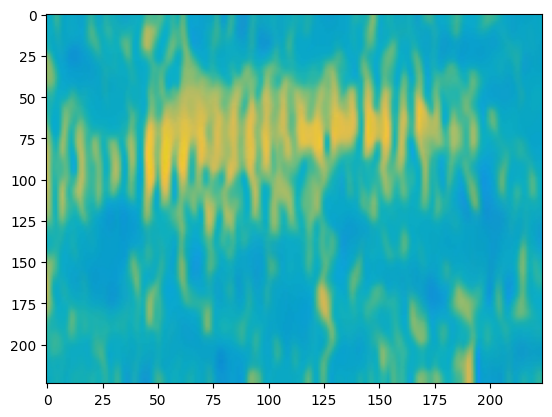

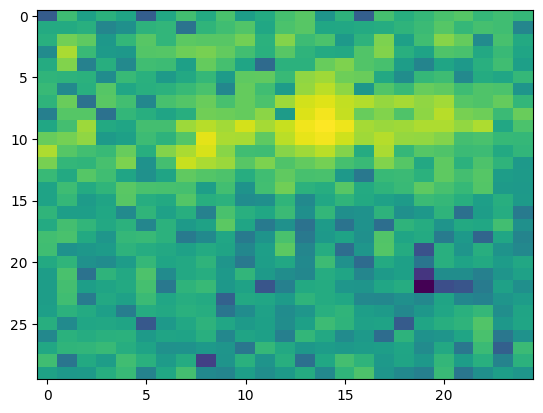

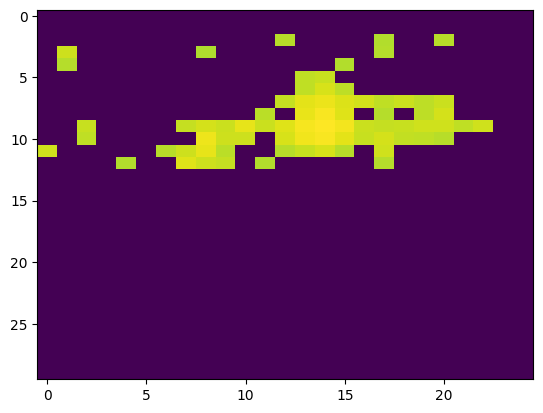

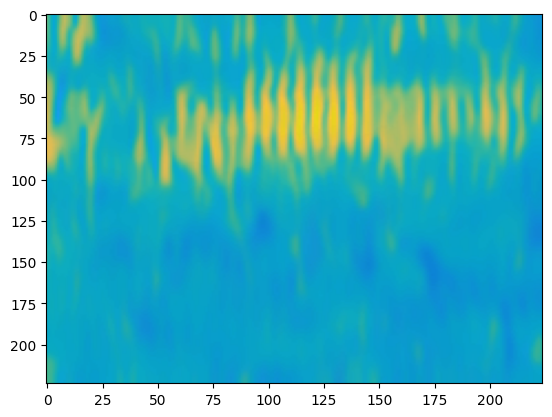

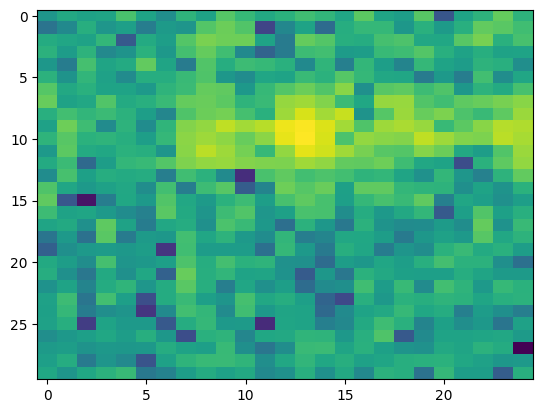

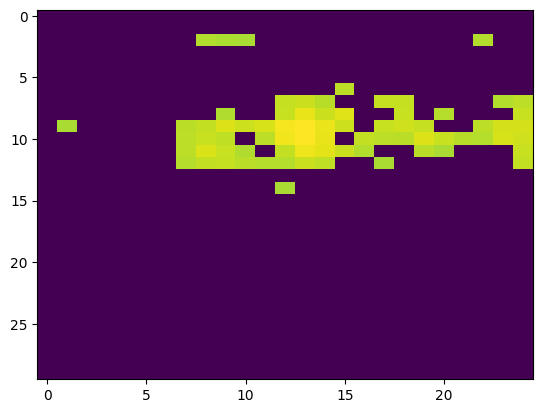

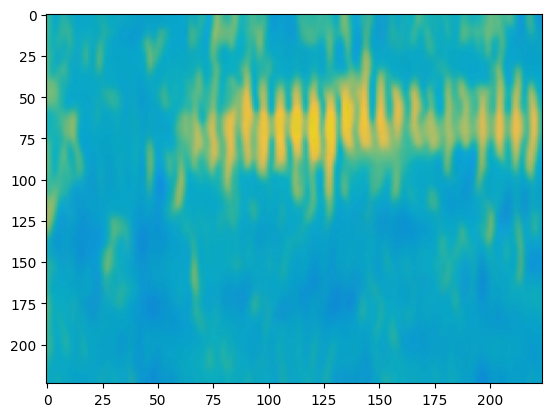

  0%|          | 0/17 [00:00<?, ?it/s]

5 Confirmed Blue-A calls in hour 0
12 Possible Blue-B calls in hour 0
(1001, 3600)


0it [00:00, ?it/s]

0 Confirmed Humpback calls in hour 0



  0%|          | 0/24 [00:00<?, ?it/s]

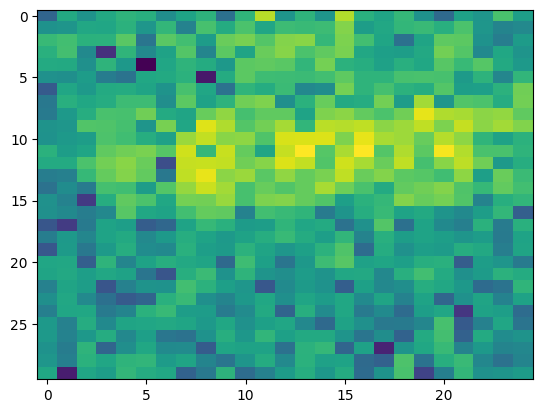

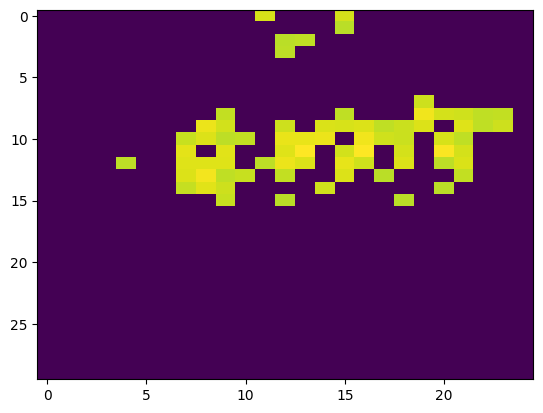

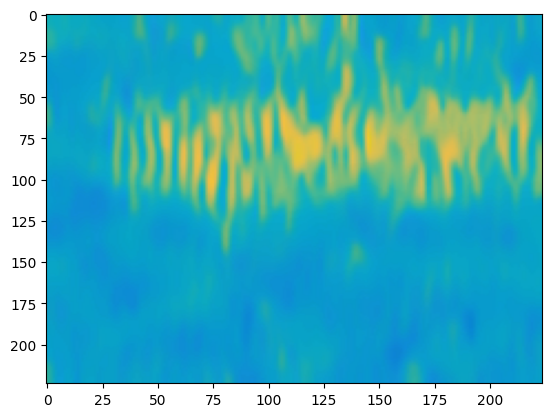

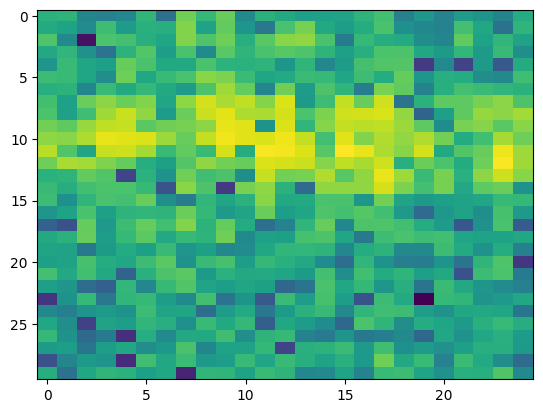

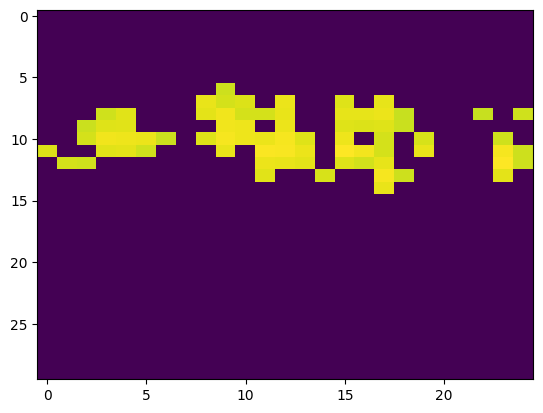

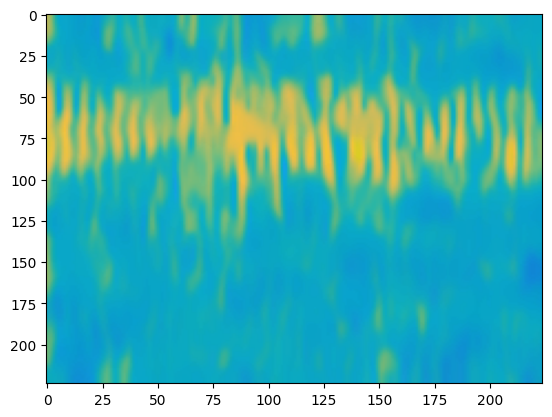

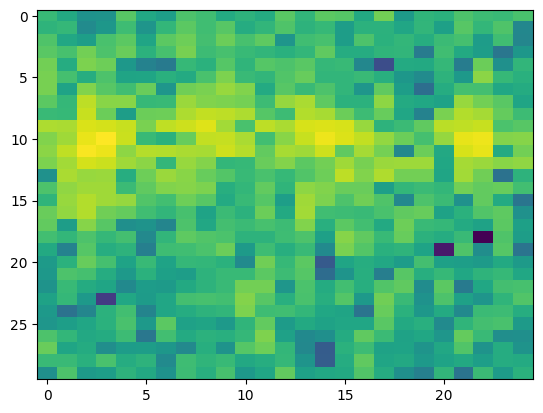

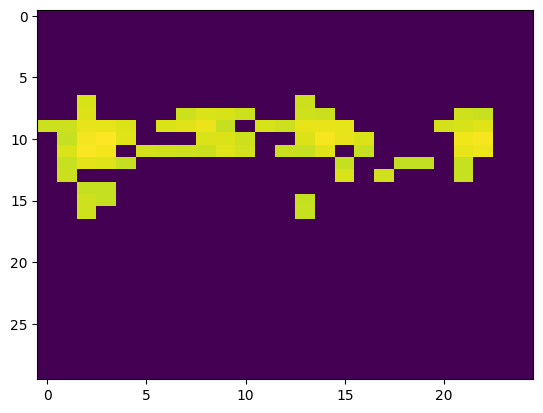

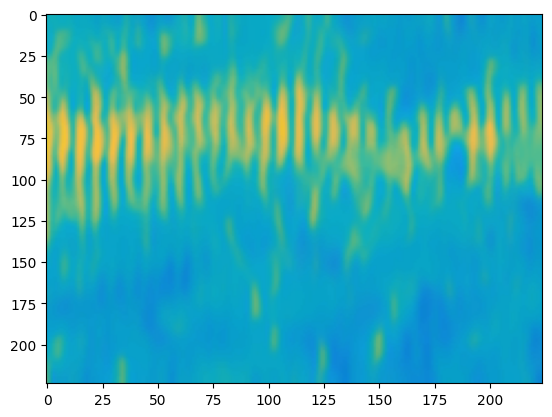

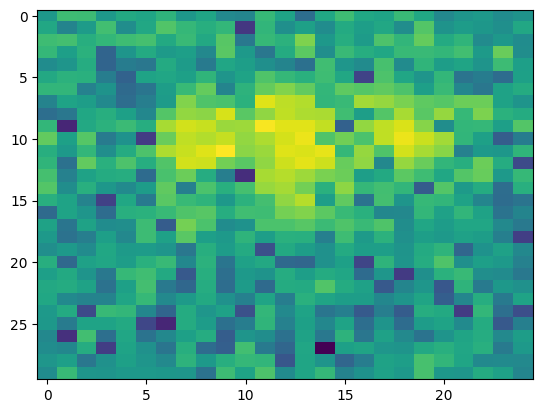

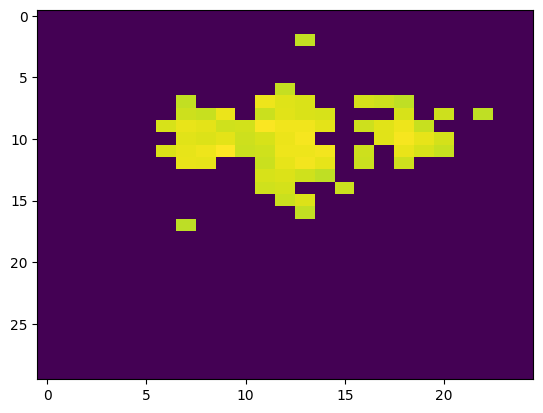

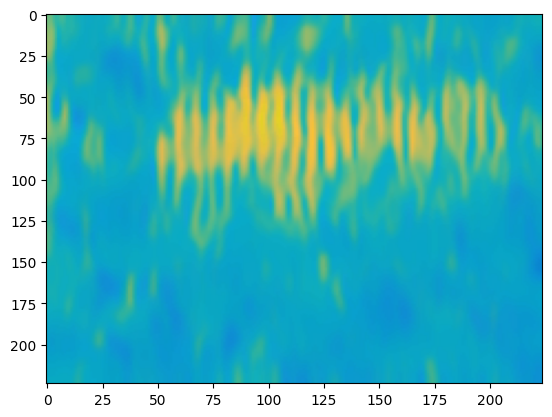

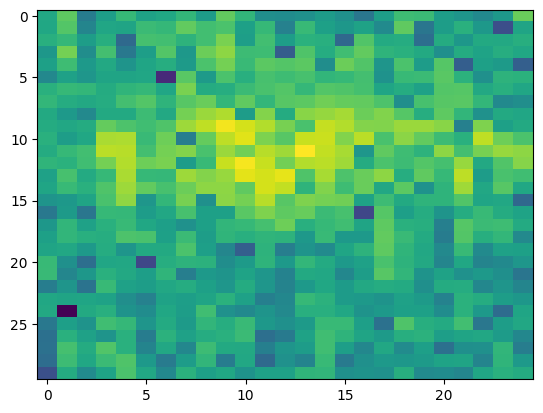

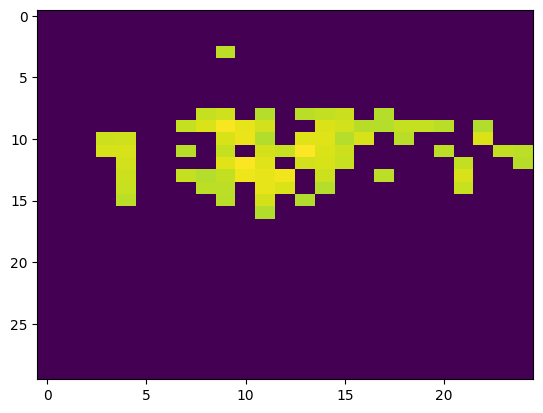

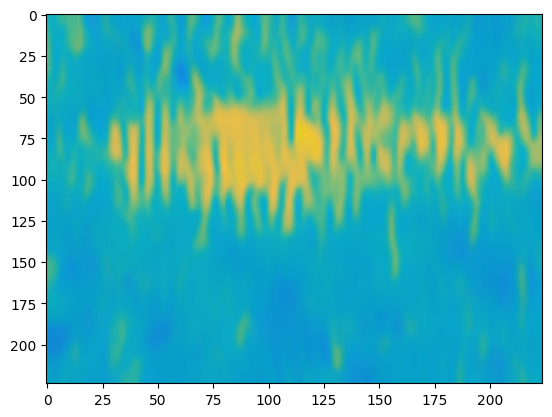

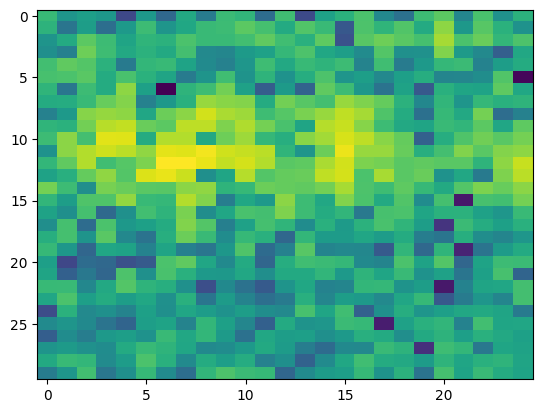

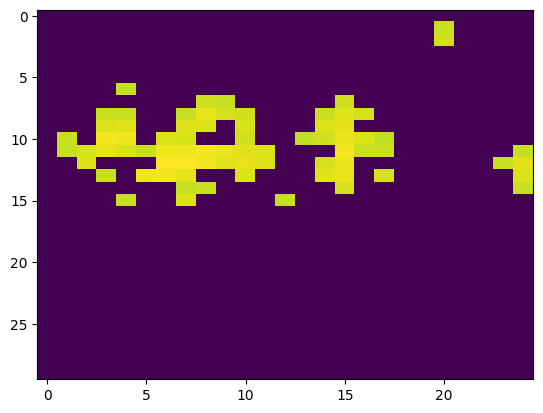

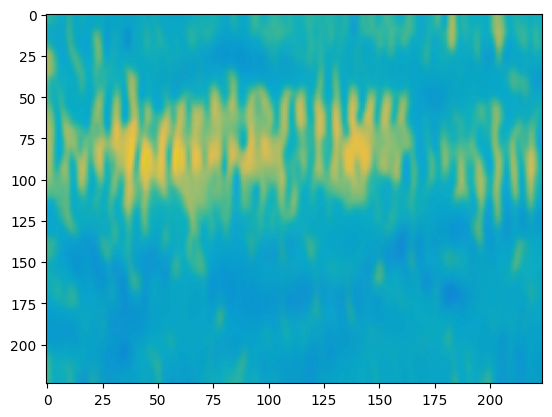

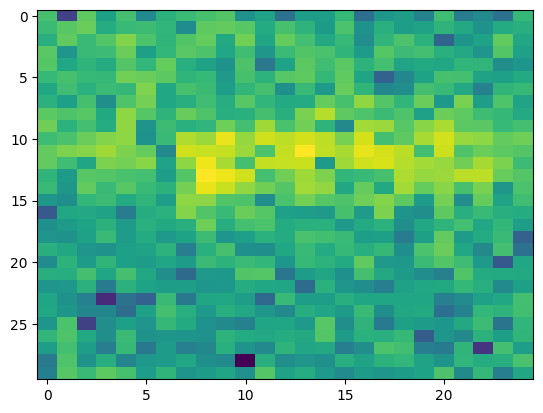

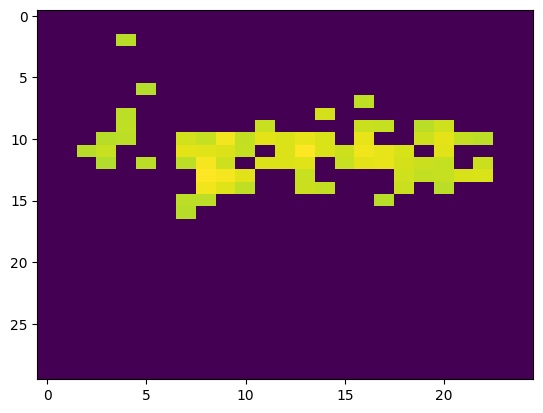

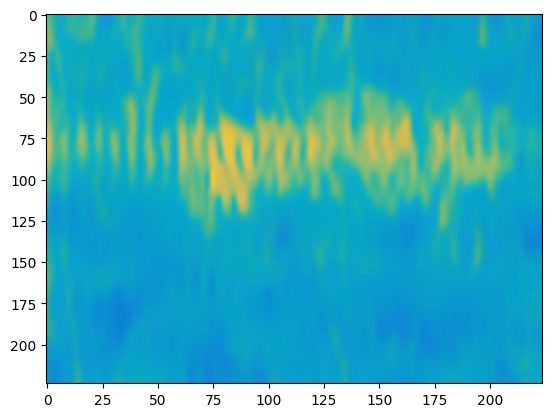

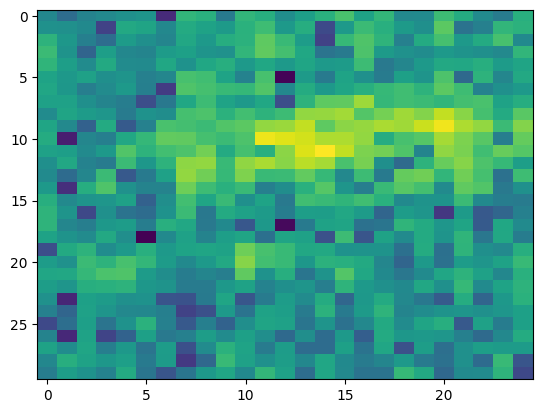

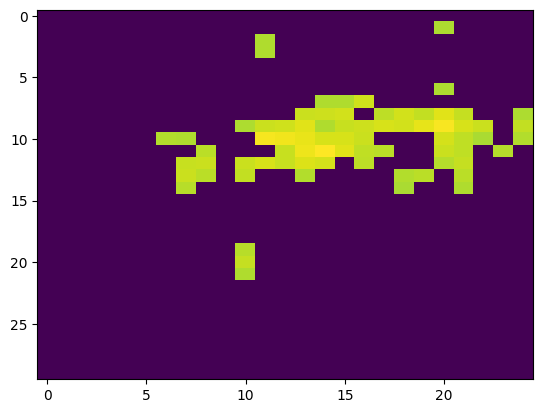

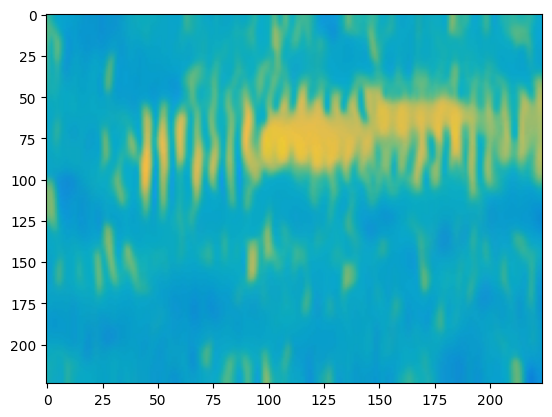

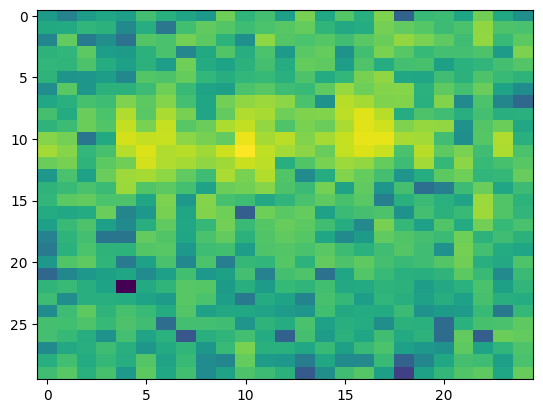

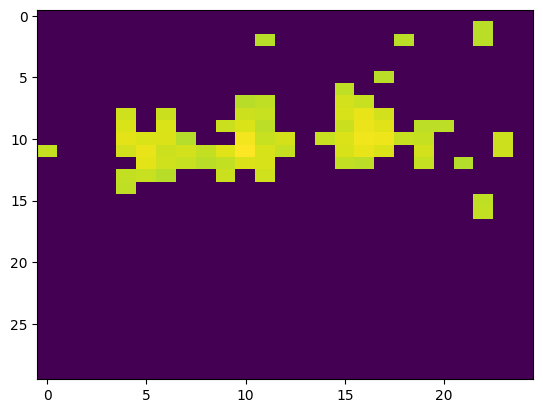

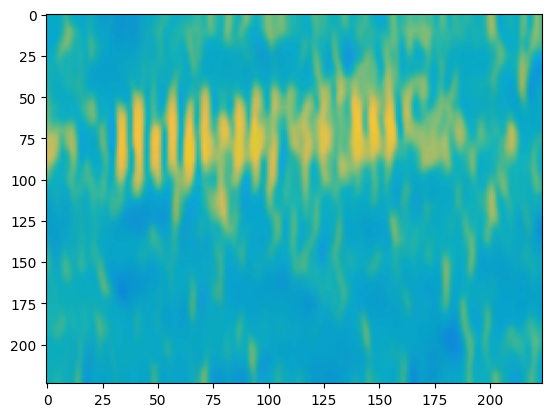

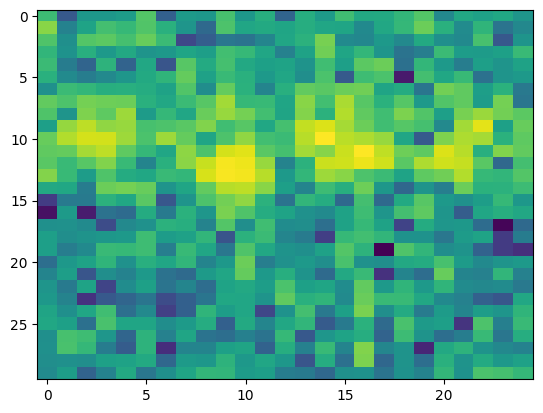

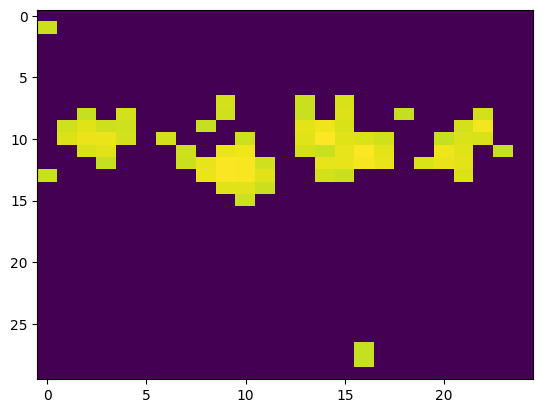

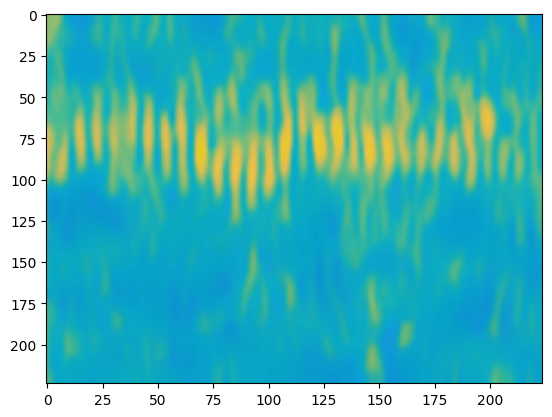


KeyboardInterrupt



In [28]:
for wav_filename, wav_filename_full in zip(all_filenames, all_filenames_full):
  
    print(wav_filename)
    if  os.path.exists(os.path.join(r'C:\Users\vikas\OneDrive\Artash_Python\2023 Test\1 - Whale Detection\Annotations2', date+'.xlsx')):
        

        labels = []

        for start_hour in range(0, 24):

            date = wav_filename.split('-')[1].split('T')[0]

            start_frame = int(SAMPLE_RATE * start_hour * 3600)
            duration_frames =  int(SAMPLE_RATE* 3600)

            pacsound_file = sf.SoundFile(wav_filename_full)
            pacsound_file.seek(start_frame)
            x = pacsound_file.read(duration_frames, dtype='float32')
            x_2k = scipy.signal.resample(x, (2000*3600))
            labels+=Analysis(x_2k, start_hour, date)
            labels+=humphback_analysis(x_2k, start_hour, date)
            print()

        df = pd.DataFrame(labels, columns= ['Date', 'Hour','Second', 'Label', 'Confidence', 'Duration', 'Mean Frequency', 'L50 Power', 'L90 Power', 'L99 Power', '63 Hz Third Band'])
        df.to_excel(os.path.join(r'C:\Users\vikas\OneDrive\Artash_Python\2023 Test\1 - Whale Detection\Annotations2', date+'.xlsx'))